# Introducing Lengthscale-Informed Sparse Grids

Welcome to this tutorial aimed at constructing kernel interpolants (equivalently fitting Gaussian processes) in high dimensions using lengthscale-infomred sparse grids (LISGs). In this tutorial we will:
- Construct a LISG design, subject to an assumed degree of lengthscale-anisotropy
- Given a function, fit a separable Matern kernel interpolant using traing points in a LISG design
- Perform some testing on a function with known anistropy. 

In [2]:
# Import packages:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Import modules:
import kernels
import LISG
import emulator

## Gaussian process emulation and kernel interpolation

### Setup: Surrogate modelling
We wish to approximate a function $f:\Omega\subset\mathbb{R}^d\rightarrow \mathbb{R}$ for which we only have access to point evaluations, however we have total control over the locations of these evaluations. We choose to model $f$ as a Gaussian process (GP).

- Attach a prior GP to $f$,
   $$
   f_{0}\sim \textrm{GP}(m(\cdot),\varphi(\cdot,\cdot)),
   $$
   
  where we choose a prior covariance kernel $\varphi:\Omega\times\Omega\rightarrow\mathbb{R}$, and, for simlicity, take a prior mean of $m=0$.
Below we illustrate a one dimensional example, where $\Omega=[-3,3]$ and $f(x)=\sin(x)$. We plot the prior mean and prior marginal variance (around the mean, using Gaussian kernel).

(-3.0, 3.0)

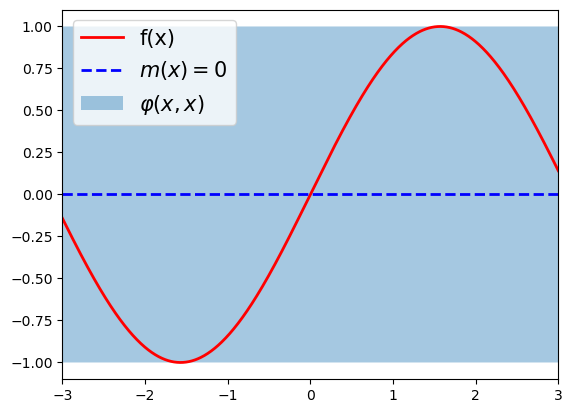

In [31]:
def f(x):
    '''
    Example function.
    '''
    return np.sin(x)

# Plotting.
resolution = 1000                # Plotting resolution.
x = np.linspace(-3,3,resolution) 

fig, ax = plt.subplots()

ax.plot(x,f(x),color='red', linewidth=2, label=r'f(x)')
ax.plot(x,np.zeros(resolution), 'blue', linestyle='dashed', linewidth=2,label=r'$m(x)=0$')
ax.fill_between(x,np.ones(resolution),-np.ones(resolution),alpha=0.4,label=r'$\varphi(x,x)$')
ax.legend(fontsize=15)

ax.set_xlim(-3,3)

- Generate data in the form of evaluations of $f$ at points in $\mathcal{X}=\{x_1,\dots,x_N\}$,

    $$
    D=\{(x,f(x))\}_{x\in\mathcal{X}}.\\
    $$
    
- Update the prior GP assuming noiseless observations, resulting in posterior mean and covariances given by
    
    $$
    m^f_{\mathcal{X}}(x) = \varphi(x,\mathcal{X})^T\varphi(\mathcal{X},\mathcal{X})^{-1}f(\mathcal{X}) \qquad\qquad \varphi_{\mathcal{X}}(x^{(1)},x^{(2)}) = \varphi(x^{(1)},x^{(2)})-\varphi(x^{(1)},\mathcal{X})^T\varphi(\mathcal{X},\mathcal{X})^{-1}\varphi(x^{(2)},\mathcal{X}),
    $$
    
   respectively, where $\varphi(x,\mathcal{X})_i=\varphi(x,x_i)$, $f(\mathcal{X})_i=f(x_i)$ and $\varphi(\mathcal{X},\mathcal{X})_{ij}=\varphi(x_i,x_j)$.
   
Below we plot the corresponding posterior mean and marginal variance, with design $\mathcal{X}=\{-2,0,1.5\}$.
    

(-3.0, 3.0)

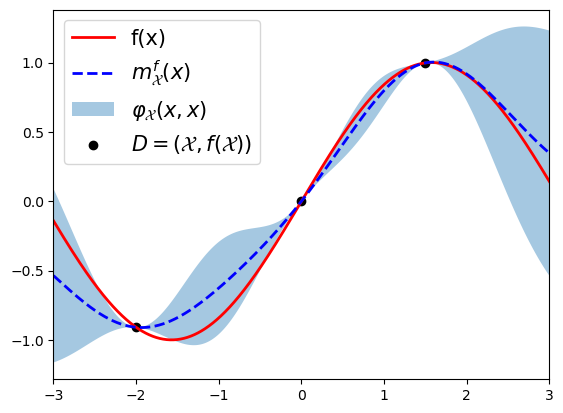

In [63]:
def k(arg1,arg2):
    '''
    Gaussian kernel.
    '''
    return np.exp(-abs(arg1-arg2)**2/2)

# Evaluate f at design points.
design = np.array([-2,0,1.5])
f_array = f(design)

# Build inverse covariance matrix.
X1, X2 = np.meshgrid(design,design)
covar_mat = k(X1, X2)
inv_covar_mat = np.linalg.inv(covar_mat) # Don't do this in practice!

# 
posterior_mean = np.array([k(x_i,design).T @ inv_covar_mat @ f_array for x_i in x])
posterior_marginal_var = np.array([1-k(x_i,design).T @ inv_covar_mat @ k(x_i,design) for x_i in x])

fig, ax = plt.subplots()



ax.plot(x,f(x),color='red', linewidth=2, label=r'f(x)')
ax.plot(x,posterior_mean, 'blue', linestyle='dashed', linewidth=2,label=r'$m^f_{\mathcal{X}}(x)$')
ax.fill_between(
    x,
    posterior_mean+posterior_marginal_var,
    posterior_mean-posterior_marginal_var,
    alpha=0.4,
    label=r'$\varphi_{\mathcal{X}}(x,x)$'
)
ax.scatter(design, f_array, color='black', label=r'$D=(\mathcal{X},f(\mathcal{X}))$')

ax.legend(fontsize=15)
ax.set_xlim(-3,3)

- The posterior mean function, $m^f_{\mathcal{X}}$, can thus be used as an approximation of $f$, and the posterior marginal variance $\varphi_{\mathcal{X}}(\cdot,\cdot)$ can be considered a local measure of uncertainty in this approximation.


- In particular, the posterior mean function is a kernel interpolant, defined by

    $$
    m^f_{\mathcal{X}} = s_{\mathcal{X},\varphi}(f) = {\arg\min}_{g\in\mathcal{N}_{\varphi}(\Omega),\, g(\mathcal{X})=f(\mathcal{X})}\|g\|_{\mathcal{N}_{\varphi}(\Omega)},
    $$
    
   i.e. $s_{\mathcal{X},\varphi}(f)$ is the function in the Naive space (reproducing kernel Hilbert space) of the kernel $\varphi$ of minimum norm that interpolates the funciton $f$ at the design points $\mathcal{X}$.
  
- We are interested in constructing designs, $\mathcal{X}\subset\Omega$, and prior covariance kernels, $\varphi:\Omega\times\Omega\rightarrow\mathbb{R}$, that minimise the approximation error

    $$
    \|f-s_{\mathcal{X},\varphi}(f)\|.
    $$
  In particular, we want to construct these such that this error is controlled as the dimension, $d$, increases.

## Matern kernels and separable Matern kernels

Matern kernels $\phi_{\nu,\lambda}:\mathbb{R}^d\times\mathbb{R}^d\rightarrow\mathbb{R}_{>0}$ are a commonly used class of postive-definite kernels. For $\mathbf{x}^{(1)},\mathbf{x}^{(2)}\in\mathbb{R}^d$, the general definition is given by

$$
\phi_{\nu,\lambda}(\mathbf{x}^{(1)},\mathbf{x}^{(2)})=\sigma^2\frac{2^{1-\nu_j}}{\Gamma(\nu)}\left(\sqrt{2\nu}\frac{\|\mathbf{x}^{(1)}-\mathbf{x}^{(2)}\|_2}{\lambda}\right)^{\nu}K_{\nu}\left(\sqrt{2\nu}\frac{\|\mathbf{x}^{(1)}-\mathbf{x}^{(2)}\|_2}{\lambda}\right),
$$

where $K_{\nu}$ is the Bessel function of the second kind. The three hyperparameters, $\nu,\lambda,\sigma\in\mathbb{R}_{>0}$ denote the regularity, the lengthscale and the standard deviation, respectively. For specific realisations of the regularity, this expression simplifies to more well-known kernels, for example, the exponential and Gaussian kernels,

$$
\phi_{0.5,\lambda}(\mathbf{x}^{(1)},\mathbf{x}^{(2)})=\sigma^2e^{-\|\mathbf{x}^{(1)}-\mathbf{x}^{(2)}\|_2/\lambda}\qquad\textrm{and}\qquad\phi_{\nu\rightarrow\infty,\lambda}(\mathbf{x}^{(1)},\mathbf{x}^{(2)})=\sigma^2e^{-\|\mathbf{x}^{(1)}-\mathbf{x}^{(2)}\|_2^2/2\lambda^2}.
$$

Below we plot four one-dimesional Matern kernels, one argument fixed at the origin, each with different regularity. 


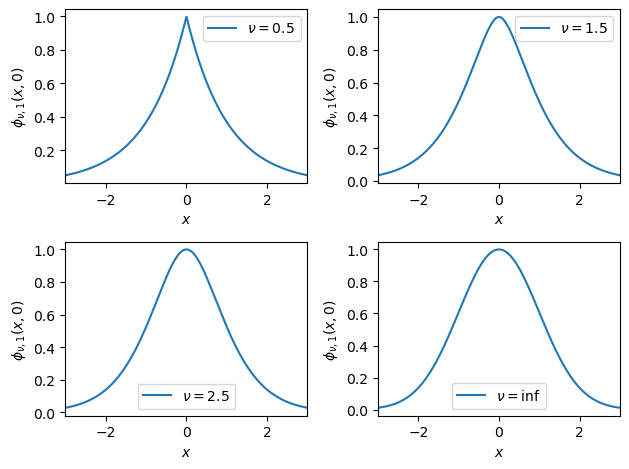

In [9]:
# Construct one-dimensionl Matern kernel objects and plot.

# Hyperparameters.
nu = [[0.5,1.5],[2.5,'inf']]
lengthscale = [[1,1],[1,1]]

# Intitialise kernels.
matern_kernel_array = np.empty((2,2), dtype=object)
for i in range(2):
    for j in range(2):
        matern_kernel_array[i,j] = kernels.maternKernel(
            nu[i][j],
            lengthscale[i][j]
        )

# Plotting.
x0 = np.zeros(resolution)

fig, ax = plt.subplots(2,2)
for i in range(2):
    for j in range(2):
        ax[i,j].plot(
            x,
            matern_kernel_array[i,j](x, x0),
            label=r'$\nu=$'+f'{nu[i][j]}'
        )
        ax[i,j].legend()
        ax[i,j].set_xlabel(r'$x$')
        ax[i,j].set_ylabel(r'$\phi_{\nu,1}(x,0)$')
        ax[i,j].set_xlim(-3,3)
fig.tight_layout()

Separable Matern kernels, $\Phi_{\boldsymbol{\nu},\boldsymbol{\lambda}}:\mathbb{R}^d\times\mathbb{R}^d\rightarrow\mathbb{R}$ in $d$-dimensions are simply products of lower dimensional Matern kernels. Specifically, we will consider only products of $d$-many one-dimensional kernels, so, for $\mathbf{x}^{(1)},\mathbf{x}^{(2)}\in\mathbb{R}^d$, we define

$$
\Phi_{\boldsymbol{\nu},\boldsymbol{\lambda}}(\mathbf{x}^{(1)},\mathbf{x}^{(2)})=\prod_{j=1}^d \phi_{\nu,\lambda}(x^{(1)}_i,x^{(2)}_i),
$$

where $\boldsymbol{\nu}=(\nu_1,\dots,\nu_d)\in\mathbb{R}^d_{>0}$ and $\boldsymbol{\lambda}=(\lambda_1,\dots,\lambda_d)\in\mathbb{R}^d_{>0}$, and each $\phi_{\nu,\lambda}:\mathbb{R}\times\mathbb{R}\rightarrow\mathbb{R}_{>0}$.

Below we plot a separable Matern kernel, $\Phi_{\boldsymbol{\nu},\boldsymbol{\lambda}}$, $d=2$, with $\boldsymbol{\nu}=(0.5,1.5)$ and $\boldsymbol{\lambda}=(1,1)$.

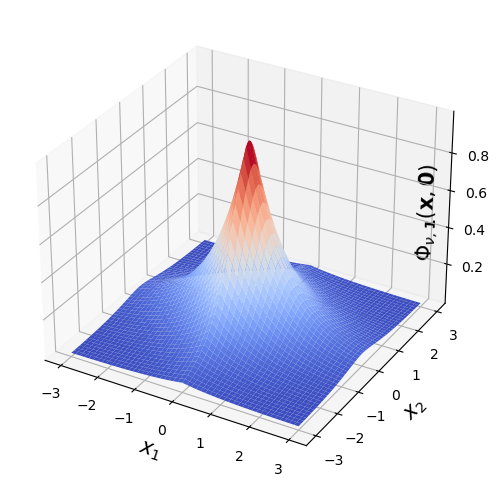

In [76]:
matern_kernel_array[0,0].lengthscale = lengthscale[0][0]

X1, X2 = np.meshgrid(x,x)
Y = np.empty((resolution, resolution), dtype=float)

for i in range(resolution):
    for j in range(resolution):
        Y[i,j] = matern_kernel_array[0,0](X1[i,j],0)\
                    * matern_kernel_array[0,1](X2[i,j],0)

fig, ax = plt.subplots(figsize=(6,8),subplot_kw={"projection": "3d"})    
surf = ax.plot_surface(
    X1,
    X2,
    Y,
    cmap=cm.coolwarm
)

ax.set_xlabel(r'$x_1$',fontsize=15)
ax.set_ylabel(r'$x_2$',fontsize=15)
ax.set_zlabel(
    r'$\Phi_{\nu,\mathbf{1}}(\mathbf{x},\mathbf{0})$',
    labelpad=-30,
    fontsize=15
)
plt.show()

## Stretching kernels with lengthscales

LISGs aim to exploit anistropy in the function $f$ characterised by the lengthscale parameter, $\lambda$. We note that, by increasing $\lambda$, the kernels are stretched horizontally.

Below we compare two one-dimensional Matern 1/2 kernels with different lengthscales, $\phi_{0.5,1}(x,0)$ and $\phi_{0.5,4}(x,0)$.

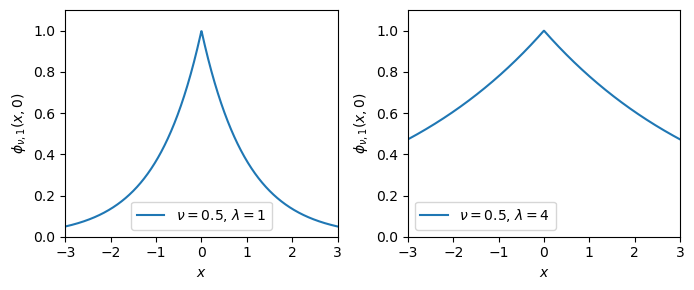

In [77]:
# Update lengthscale of first kernel
new_lengthscale = 4

matern_kernel_array[0,0].lengthscale = lengthscale[0][0]

fig, ax = plt.subplots(1,2,figsize=(7,3))

ax[0].plot(
    x,
    matern_kernel_array[0,0](x, x0),
    label=r'$\nu=$'+f'{nu[0][0]}'+r', $\lambda=$'+f'{lengthscale[0][0]}'
)
ax[0].legend()
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$\phi_{\nu,1}(x,0)$')
ax[0].set_ylim(0,1.1)
ax[0].set_xlim(-3,3)

matern_kernel_array[0,0].lengthscale = new_lengthscale

ax[1].plot(
    x,
    matern_kernel_array[0,0](x, x0),
    label=r'$\nu=$'+f'{nu[0][0]}'+r', $\lambda=$'+f'{new_lengthscale}'
)
ax[1].legend()
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$\phi_{\nu,1}(x,0)$')
ax[1].set_ylim(0,1.1)
ax[1].set_xlim(-3,3)

fig.tight_layout()

If we consider a function $f$ to be anisotropic according to $\boldsymbol{\lambda}=(\lambda_1,\dots,\lambda_d)$, we aim to approximate with similarly 'stretched' separable Matern kernels. In particular, we assume
$$
\|f\|_{\mathcal{N}_{\Phi_{\boldsymbol{\nu},\boldsymbol{\lambda}}}}\leq C,
$$
where the norm is the Native space (or reproducing kernel Hilbert space) norm corresponding to $\Phi_{\boldsymbol{\nu},\boldsymbol{\lambda}}$.

Below we plot a stretched separable Matern kernel, $\Phi_{\boldsymbol{\nu},\boldsymbol{\lambda}}$, $d=2$, with $\boldsymbol{\nu}=(0.5,1.5)$ and $\boldsymbol{\lambda}=(4,1)$.

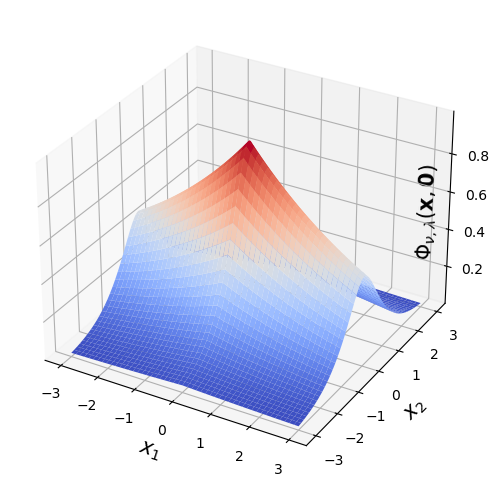

In [79]:
X1, X2 = np.meshgrid(x,x)
Y = np.empty((resolution, resolution), dtype=float)

matern_kernel_array[0,0].lengthscale = new_lengthscale

for i in range(resolution):
    for j in range(resolution):
        Y[i,j] = matern_kernel_array[0,0](X1[i,j],0)\
                    * matern_kernel_array[0,1](X2[i,j],0)

fig, ax = plt.subplots(figsize=(6,8),subplot_kw={"projection": "3d"})    
surf = ax.plot_surface(
    X1,
    X2,
    Y,
    cmap=cm.coolwarm
)

ax.set_xlabel(r'$x_1$',fontsize=15)
ax.set_ylabel(r'$x_2$',fontsize=15)
ax.set_zlabel(
    r'$\Phi_{\nu,\lambda}(\mathbf{x},\mathbf{0})$',
    labelpad=-30,
    fontsize=15
)
plt.show()

## Constructing LISGs

## Fast Emulation

## Example